In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg


# Fixing random state for reproducibility
np.random.seed(19680801)

dx = 0.1
x_lower_limit = 0
x_upper_limit = 40                                       
x = np.arange(x_lower_limit, x_upper_limit, dx)
data_size = len(x)                                 # data size
noise = np.random.randn(data_size)                 # white noise

# Original dataset 
y = 2.0 + 3.0*np.cos(2*np.pi*x) + 1.0*np.cos(6*np.pi*x) + noise

In [2]:
def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [3]:
def fx(p0, p1, p2, p3, element):
    return p0 + p1*np.cos(2*np.pi*element) + p2*np.cos(4*np.pi*element) + p3*np.cos(6*np.pi*element)

def gradfx(p0, p1, p2, p3, element1, element2):
    return np.asarray([[2*(p0 + p1*np.cos(2*np.pi*element1) + p2*np.cos(4*np.pi*element1)  + p3*np.cos(6*np.pi*element1)-element2)],
            [2*np.cos(2*np.pi*element1)*(p0 + p1*np.cos(2*np.pi*element1) + p2*np.cos(4*np.pi*element1)  + p3*np.cos(6*np.pi*element1)-element2)],
            [2*np.cos(4*np.pi*element1)*(p0 + p1*np.cos(2*np.pi*element1) + p2*np.cos(4*np.pi*element1)  + p3*np.cos(6*np.pi*element1)-element2)],
            [2*np.cos(6*np.pi*element1)*(p0 + p1*np.cos(2*np.pi*element1) + p2*np.cos(4*np.pi*element1)  + p3*np.cos(6*np.pi*element1)-element2)]])

def DFP_FIT(xlist, ylist, epsilon):
    alpha=100
    nanFound = True
    tooLarge = True
    while nanFound or tooLarge:
        nanFound, tooLarge, pvalues, ypredict = DFPfit(xlist, ylist, alpha, epsilon)
        alpha/=10
    print("pvalues", pvalues)
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(x, y)
    axs[0].set_xlim(x_lower_limit, x_upper_limit)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('observation')
    axs[0].grid(True)
    
    axs[1].plot(x, ypredict)
    axs[1].set_xlim(x_lower_limit, x_upper_limit)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('model prediction')

    fig.tight_layout()
    plt.show()

def GDfit(xlist, ylist, alpha, epsilon):
    eps=epsilon
    p0=.1
    p1=.1
    p2=.1
    p3=.1
    counter=0
    for j in ylist:
        dLdp0=2*(p0 + p1*np.cos(2*np.pi*xlist[counter]) + p2*np.cos(4*np.pi*xlist[counter])  + p3*np.cos(6*np.pi*xlist[counter])-j)
        dLdp1=2*np.cos(2*np.pi*xlist[counter])*(p0 + p1*np.cos(2*np.pi*xlist[counter]) + p2*np.cos(4*np.pi*xlist[counter])  + p3*np.cos(6*np.pi*xlist[counter])-j)
        dLdp2=2*np.cos(4*np.pi*xlist[counter])*(p0 + p1*np.cos(2*np.pi*xlist[counter]) + p2*np.cos(4*np.pi*xlist[counter])  + p3*np.cos(6*np.pi*xlist[counter])-j)
        dLdp3=2*np.cos(6*np.pi*xlist[counter])*(p0 + p1*np.cos(2*np.pi*xlist[counter]) + p2*np.cos(4*np.pi*xlist[counter])  + p3*np.cos(6*np.pi*xlist[counter])-j)
        arr=np.asarray([dLdp0, dLdp1, dLdp2, dLdp3])
        p0temp=p0-dLdp0*alpha
        p1temp=p1-dLdp1*alpha
        p2temp=p2-dLdp2*alpha
        p3temp=p3-dLdp3*alpha
        if (isNaN(p0) or isNaN(p1) or isNaN(p2) or isNaN(p3)):
            print("NAN found")
            return True, False, _
        if eps*alpha*abs(linalg.norm(arr))**2 > abs(fx(p0, p1, p2, p3, xlist[counter])-fx(p0temp, p1temp, p2temp, p3temp, xlist[counter])):
            return False, True, _
        p0-=dLdp0*alpha
        p1-=dLdp1*alpha
        p2-=dLdp2*alpha
        p3-=dLdp3*alpha
        counter+=1
        pvalues = [p0, p1, p2, p3]
    return False, False, pvalues 

def DFPfit(xlist, ylist, alpha, epsilon):
    ypredict=[]
    eps=epsilon
    p0=.1
    p1=.2
    p2=.3
    p3=.4
    counter=0
    Bi=np.asarray([[1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]])
    for j in ylist:

        gradf=gradfx(p0, p1, p2, p3, xlist[counter], j)
        di=np.multiply(-Bi, gradf)
        
        ps=np.asarray([[p0],
                       [p1],
                       [p2],
                       [p3]])
        
        alphas=np.asarray([[alpha],
                           [alpha],
                           [alpha],
                           [alpha]])
        
        dialpha=np.multiply(di, alpha)
        
        pstemp=np.asarray([[p0+dialpha[0,0]],
                           [p1+dialpha[1,1]],
                           [p2+dialpha[2,2]],
                           [p3+dialpha[3,3]]])
        dps=np.subtract(pstemp, ps)
        gradfxi=gradfx(pstemp[0][0], pstemp[1][0], pstemp[2][0], pstemp[3][0], xlist[counter], j)
        gradfx0=gradfx(p0, p1, p2, p3, xlist[counter], j)
        dg=np.subtract(gradfxi, gradfx0)
        firstterm=np.divide(np.multiply(dps, np.transpose(dps)), np.multiply(np.transpose(dps), dg))
        secondterm=np.divide(np.multiply(np.multiply(Bi, dg), np.transpose(np.multiply(Bi, dg))), np.multiply(np.transpose(dg), np.multiply(Bi, dg)))
        RHS=np.subtract(firstterm, secondterm)
        Bi=np.add(Bi, RHS)
    
        if (isNaN(p0) or isNaN(p1) or isNaN(p2) or isNaN(p3)):
            print("NAN found")
            return True, False, _, _

        test=linalg.norm(gradf)
        comparator1=eps*alpha*abs(test)**2
        comparator2=abs(fx(p0, p1, p2, p3, xlist[counter])-fx(pstemp[0][0], pstemp[1][0], pstemp[2][0], pstemp[3][0], xlist[counter]))
#         print("comp 2", comparator2)
        if comparator1 > comparator2:
#             print("Too large")
            return False, True, _, _
        p0=pstemp[0][0]
        p1=pstemp[1][0]
        p2=pstemp[2][0]
        p3=pstemp[3][0]
        counter+=1
        pvalues = [p0, p1, p2, p3]
    for i in xlist:
        ypredict.append(p0 + p1*np.cos(2*np.pi*i) + p2*np.cos(4*np.pi*i)  + p3*np.cos(6*np.pi*i))
    return False, False, pvalues, ypredict



pvalues [1.948451926816308, 2.898590021442195, 0.19299246991155855, 1.1190569623591344]


C:\Users\kevak\AppData\Local\Temp/ipykernel_13700/4060904219.py:155: RuntimeWarning: invalid value encountered in true_divide
  secondterm=np.divide(np.multiply(np.multiply(Bi, dg), np.transpose(np.multiply(Bi, dg))), np.multiply(np.transpose(dg), np.multiply(Bi, dg)))


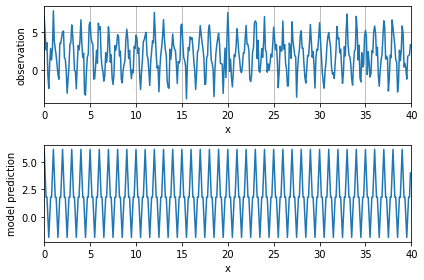

In [4]:
DFP_FIT(x, y, .005)